# Documentation

The AXL documentation is available at https://developer.cisco.com/site/axl/

AXL Developer Guide: https://developer.cisco.com/docs/axl/#!axl-developer-guide

AXL Schema Reference: https://developer.cisco.com/docs/axl-schema-reference/

The WSDL files of the UCM APIs can be downloaded from the UCM admin GUI from **Unified CM Administration > Application > Plugins** as part of the Cisco AXL Toolkit
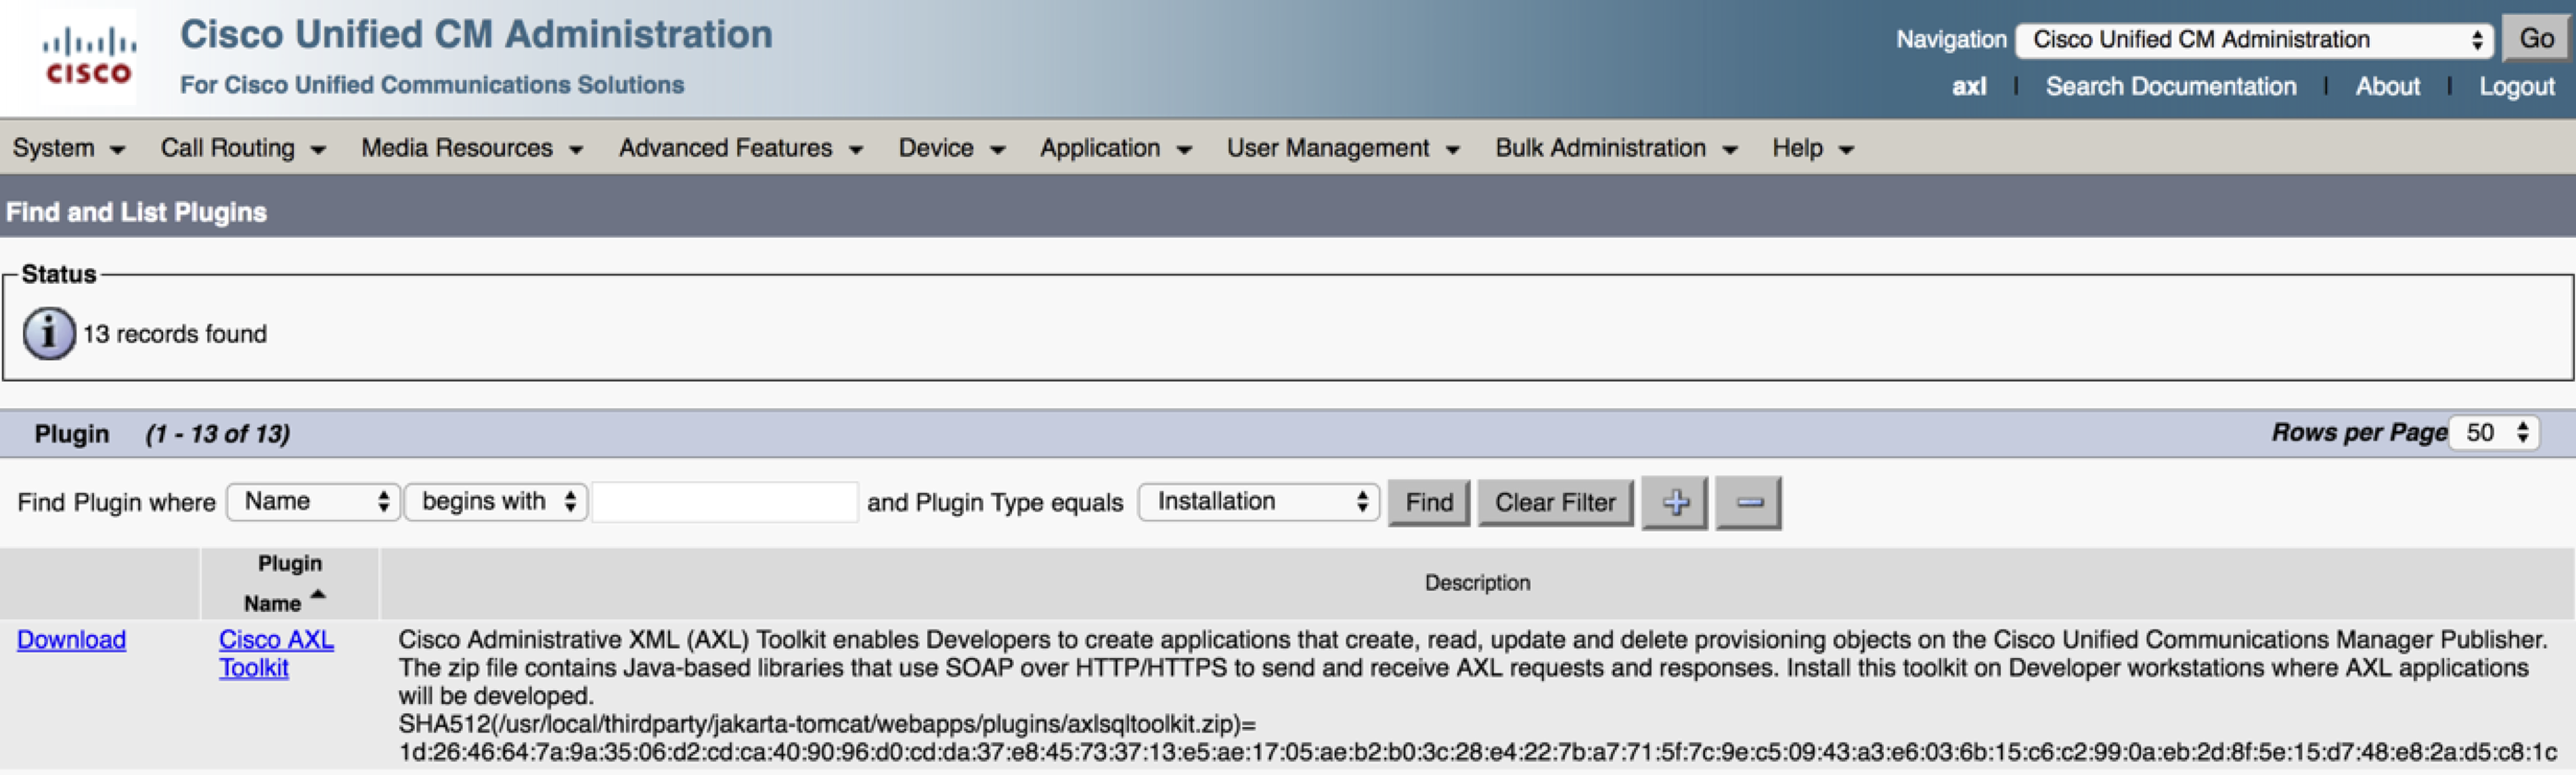

The UCM Data Dictionary can be downloaded here: https://developer.cisco.com/docs/axl/#!12-5-cucm-data-dictionary

After downloading and unzipping the Data Dictionary can be opened in a browser:
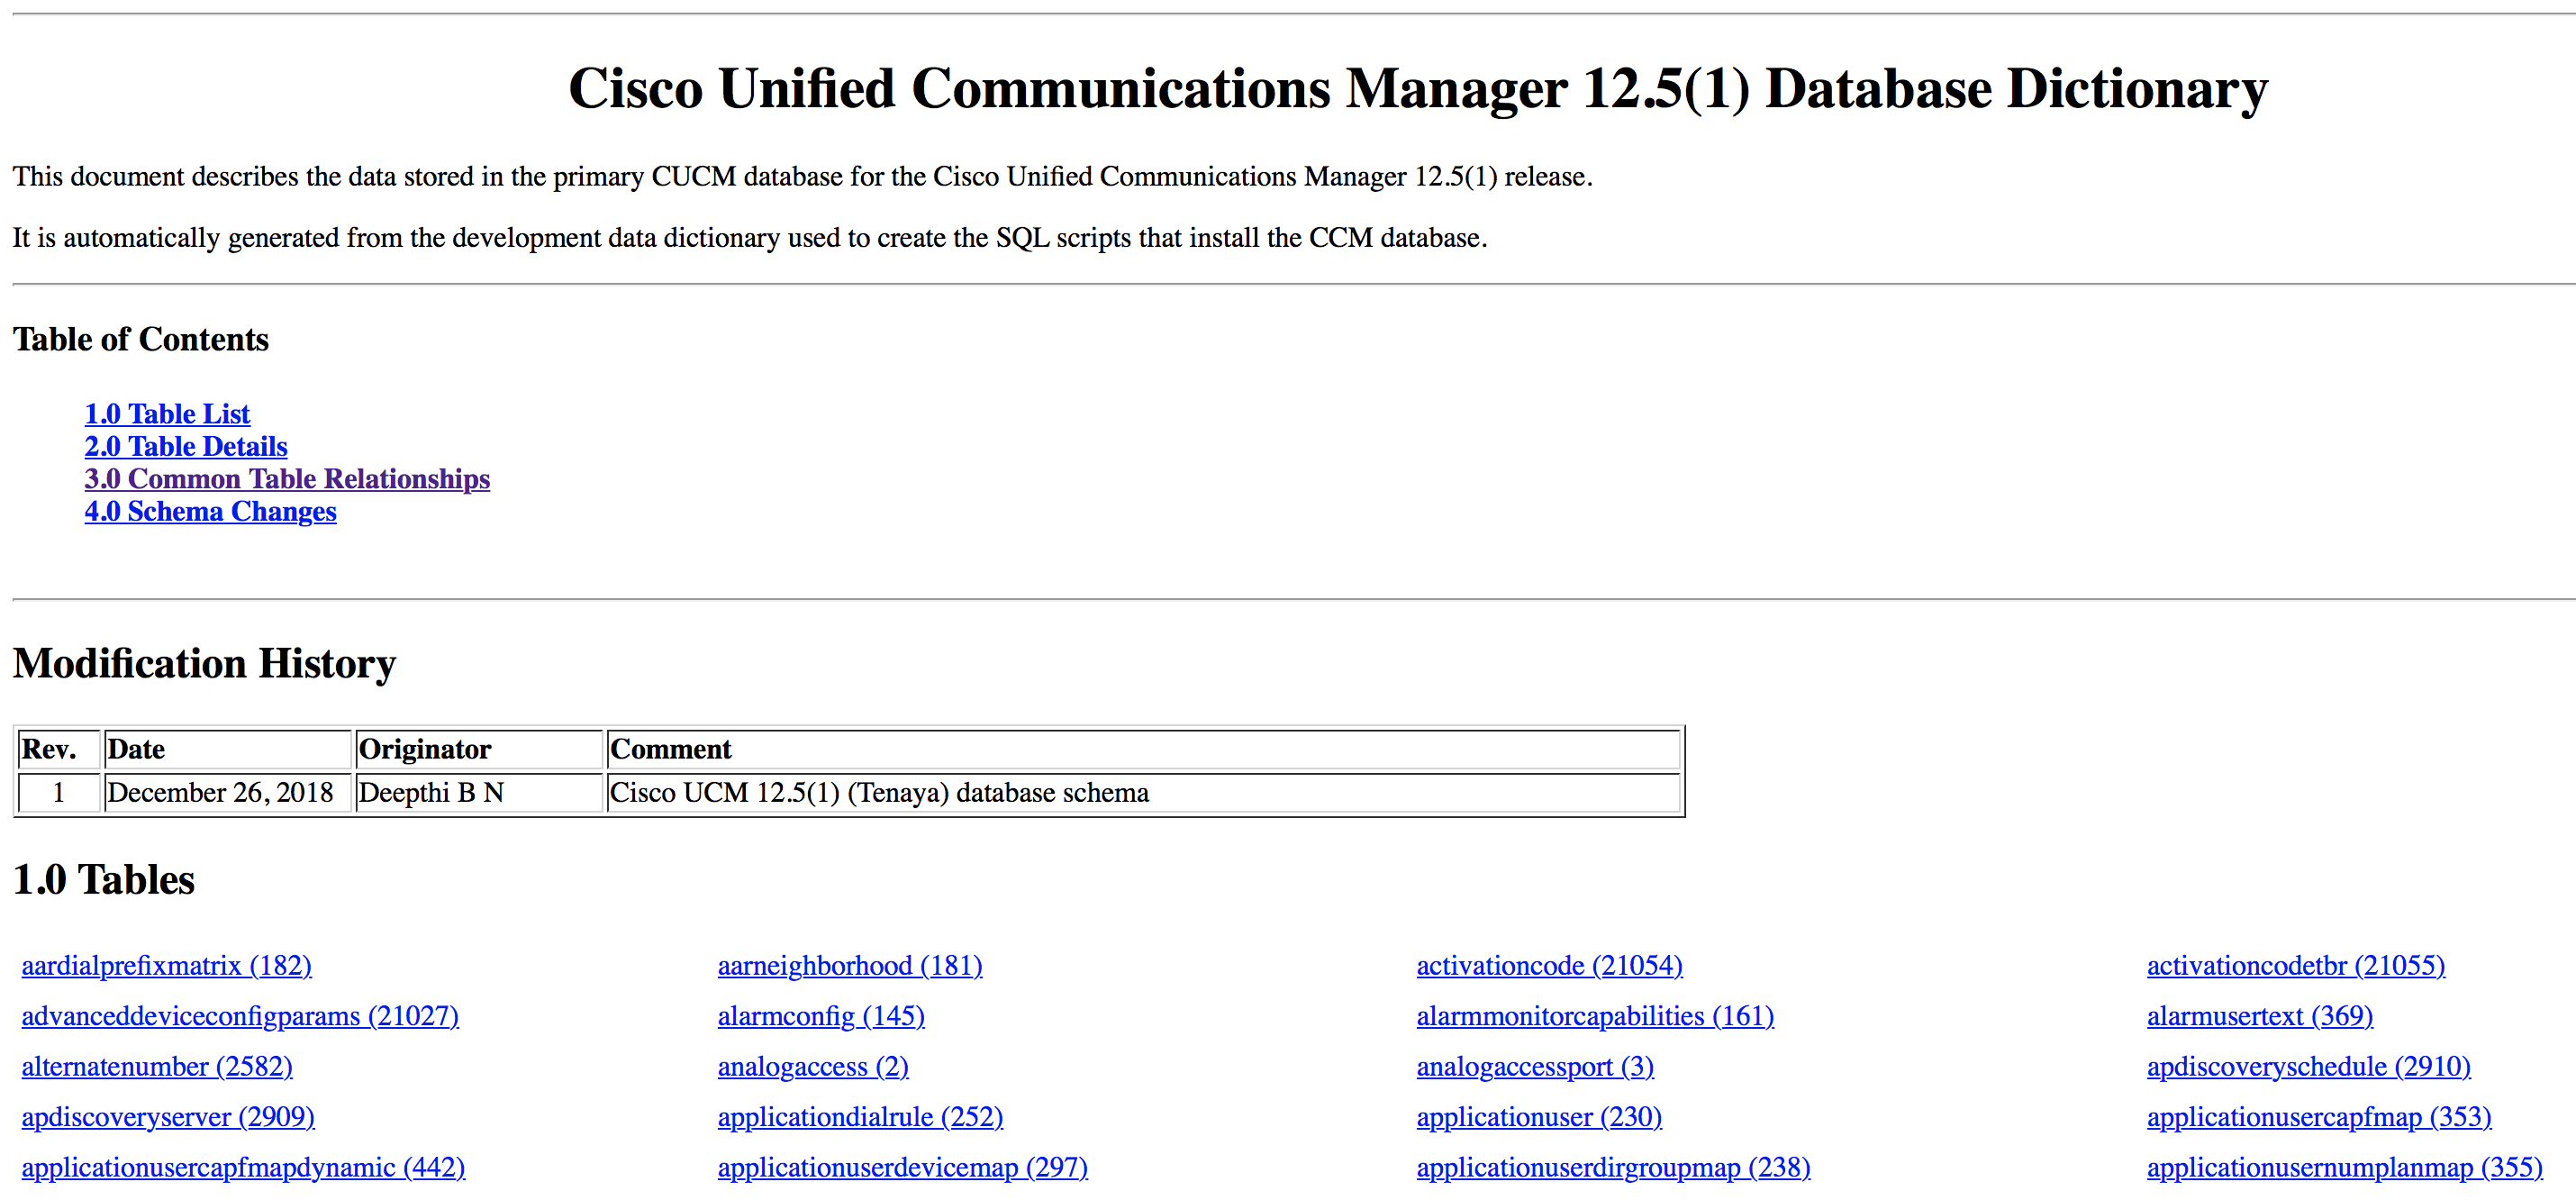

# Enabling AXL Logs

**To Do:** to enable the AXL logs please follow the procedure described here: https://developer.cisco.com/docs/axl/#!enable-and-gather-axl-api-logs/enable-and-gather-axl-api-logs

# AXL Connection Test

**If you want to follow the lab using locally installed Python and Pycharm then pls. open the Python file `01 AXL Introduction.py` and use the PyCharm Debugger to step through the Python code provided in that file**

To access the AXL service on UCM some connection parameters are required:
* IP address or FQDN of the UCM publisher
* AXL user
* AXL password

**To Do**: Execute the below code to set the variables

In [3]:
# set some connection parameters
UCM_PUBLISHER = '198.18.1.13'
AXL_USER = 'administrator'
AXL_PASSWORD = 'dCloud123!'

#from connection_parameters import *

The AXL service in the latest UCM releases is enabled by default. To check whether the AXL service is running we can simply point our browser to the URL of the AXL service.

**To Do**: Execute below cell to get the AXL url of your UCM based on above connection parameters

In [4]:
axl_endpoint = f'https://{UCM_PUBLISHER}:8443/axl'
print(axl_endpoint)

https://us-cm-pub.ent-pa.com:8443/axl


**To Do:** click on the URL above and check whether you can access the AXL service on your UCM and whether the AXL service is running.

**Don't forget to establish the AnyConnect connection to your dCloud lab instance before executing this test.**

If the AXL service is running you should see something like this:
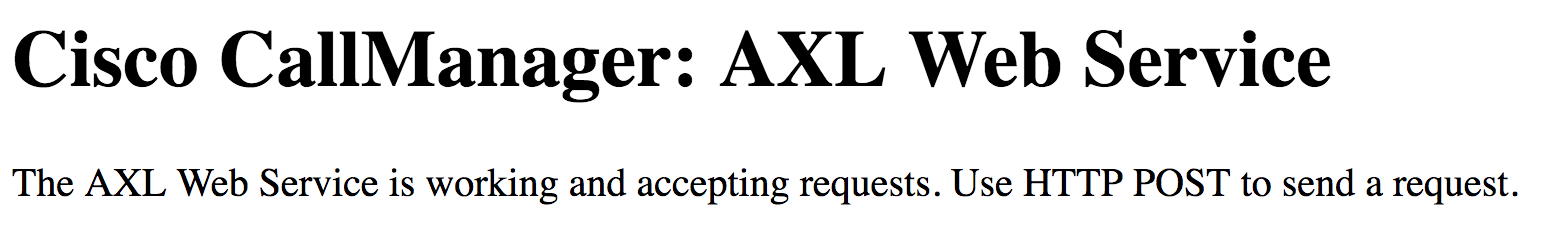

Now let's try to do the same using Python code.

**To Do:** Execute the Python code below and check the output.

In [8]:
import requests
import urllib3

# disable warnings for HTTPS sessions w/ diabled cert validation
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    
axl_endpoint = f'https://{UCM_PUBLISHER}:8443/axl'

print(f'Accessing {axl_endpoint}')
r = requests.get(axl_endpoint, auth=(AXL_USER, AXL_PASSWORD),verify=False)
r.raise_for_status()
print(r.text)


Accessing https://us-cm-pub.ent-pa.com:8443/axl
<html><head><title>Cisco CallManager: AXL Web Service</title></head><body>
<h1>Cisco CallManager: AXL Web Service</h1>
<p>The AXL Web Service is working and accepting requests.
 Use HTTP POST to send a request.</p></body></html>



## Executing a simple AXL Request directly

One of the most simple API methods is **getCCMVersion**.

This the documentation of this method from the AXL Schema Reference:

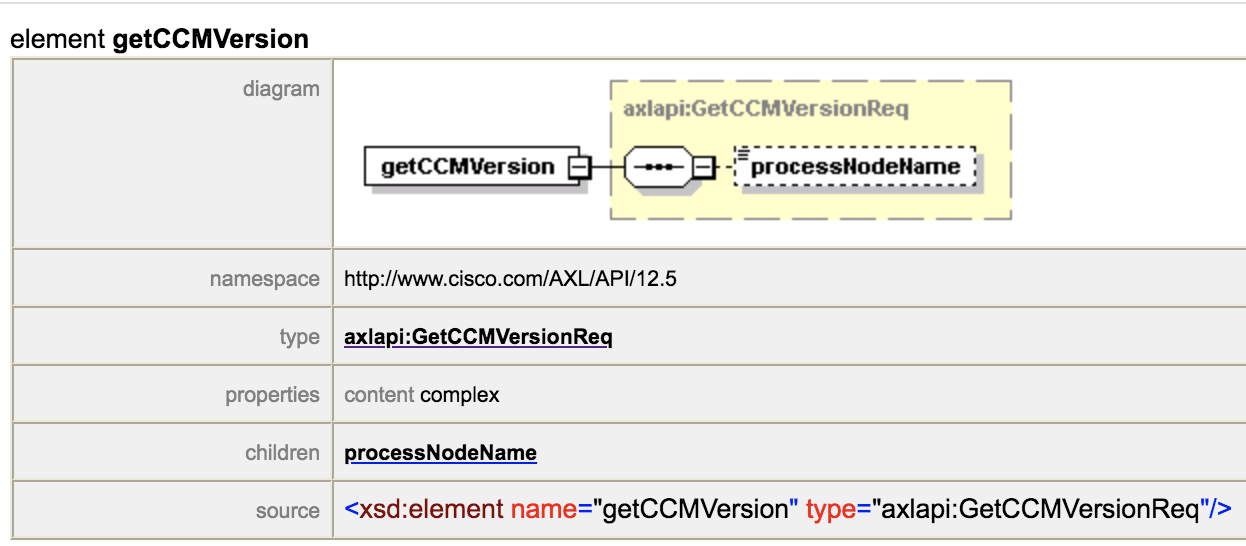

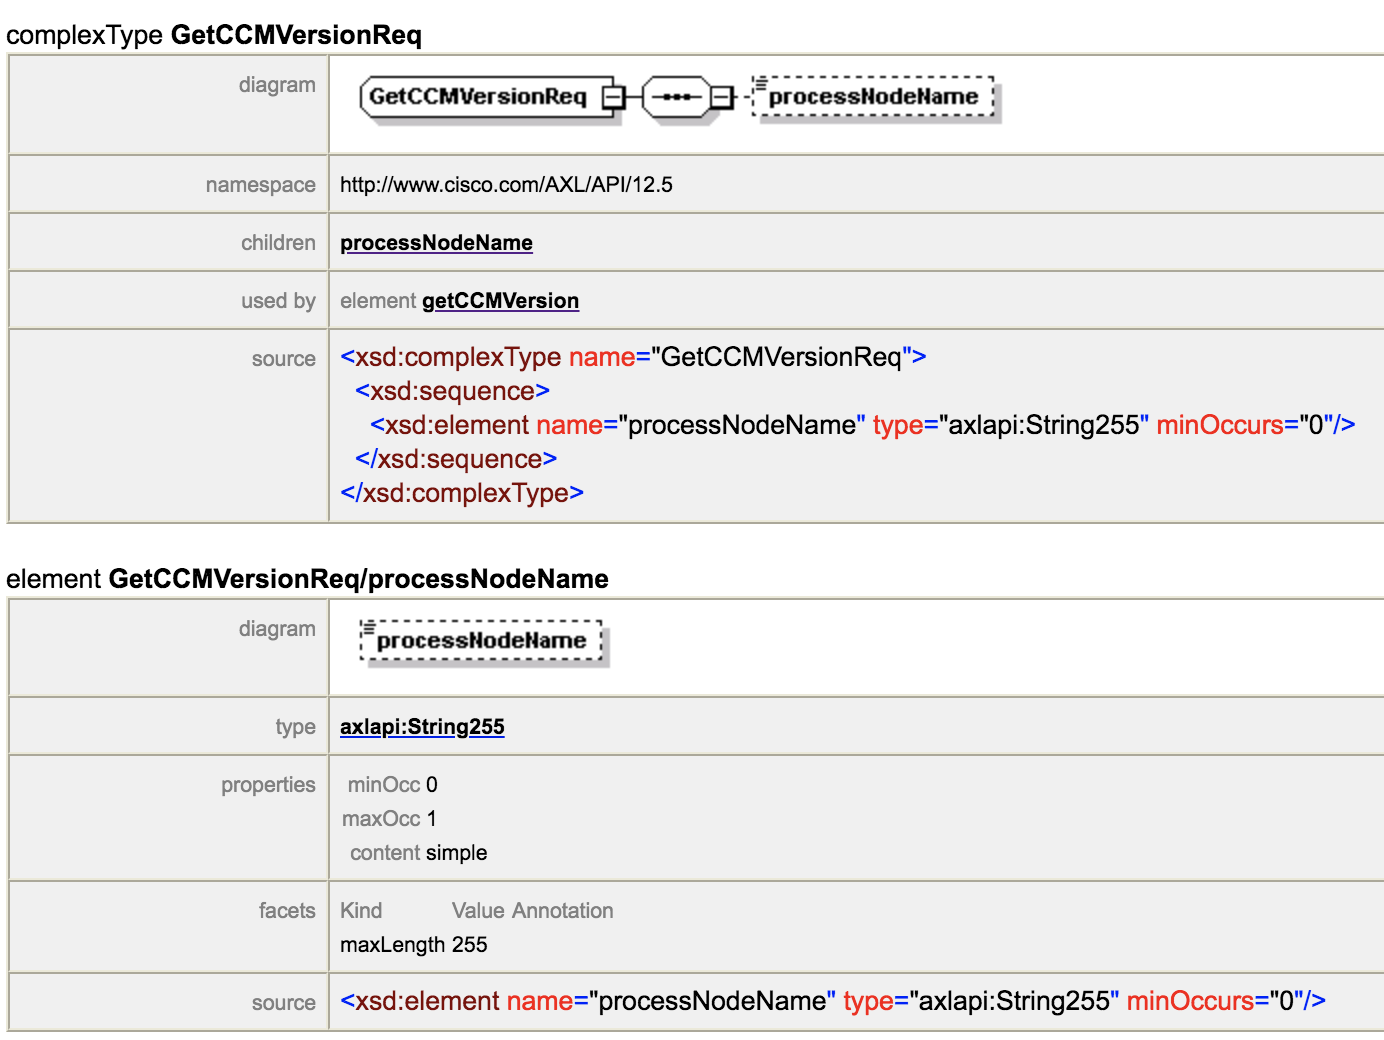

A properly formated SOAP request as determined using SoapUI is:
```
<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:ns="http://www.cisco.com/AXL/API/12.0">
   <soapenv:Header/>
   <soapenv:Body>
      <ns:getCCMVersion>
      </ns:getCCMVersion>
   </soapenv:Body>
</soapenv:Envelope>
```

Executing the request in SoapUI also gives us a good impression of what the results looks like:
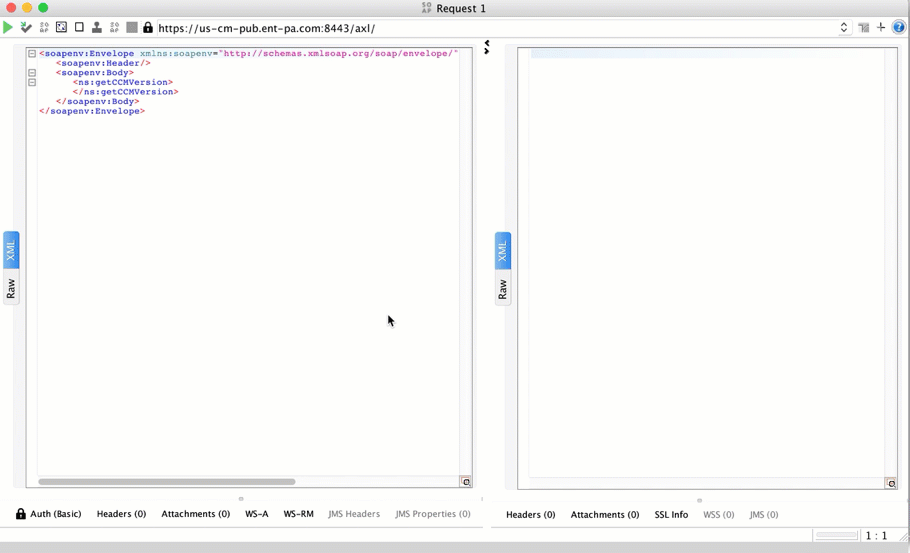

To send the same SOAP request to UCM we can use this simple Python code.

**To Do**: Execute below cell and check the output.

In [6]:
import requests
import urllib3

# disable warnings for HTTPS sessions w/ diabled cert validation
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

axl_endpoint = f'https://{UCM_PUBLISHER}:8443/axl/'

body = """<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:ns="http://www.cisco.com/AXL/API/11.0">
            <soapenv:Header/>
            <soapenv:Body>
                <ns:getCCMVersion>
                </ns:getCCMVersion>
            </soapenv:Body>
        </soapenv:Envelope>"""

headers = {
    'SOAPAction': 'CUCM:DB ver=11.0 getCCMVersion',
    'Content-Type': 'text/xml;charset=UTF-8'
}

r = requests.post(axl_endpoint, auth=(AXL_USER, AXL_PASSWORD), verify=False, data=body, headers=headers)
print(r.text)

<?xml version='1.0' encoding='UTF-8'?><soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/"><soapenv:Body><ns:getCCMVersionResponse xmlns:ns="http://www.cisco.com/AXL/API/11.0"><return><componentVersion><version>12.5.1.10000(4)</version></componentVersion></return></ns:getCCMVersionResponse></soapenv:Body></soapenv:Envelope>


## Handling XML data in Python
... but what do we do with the resulting text? There are a number of modules for handling XML data in Python: https://docs.python.org/3/library/xml.html

To be able to work with the data the XML returned has to be parsed. This can be acheived using the [`lxml` module](https://lxml.de/index.html)

**To Do**: Execute below cell and check the output.

In [7]:
from lxml import etree

# need to encode() the result to parse from bytes
element_tree = etree.fromstring(r.text.encode())
print(element_tree)

<Element {http://schemas.xmlsoap.org/soap/envelope/}Envelope at 0x1094c7aa0>


Using the `lxml` module we can now access data within the element tree. Also we can create a nicely formated version of the XML

**To Do**: Execute below cell and check the output.

In [8]:
print(etree.tostring(element_tree, pretty_print=True).decode())

<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
  <soapenv:Body>
    <ns:getCCMVersionResponse xmlns:ns="http://www.cisco.com/AXL/API/11.0">
      <return>
        <componentVersion>
          <version>12.5.1.10000(4)</version>
        </componentVersion>
      </return>
    </ns:getCCMVersionResponse>
  </soapenv:Body>
</soapenv:Envelope>



To get the returned version value we can use the `lxml` functionality.

**To Do**: Execute below cell and check the output.

In [9]:
version = element_tree.find('.//version')
print(f'Version: {version.text}')

Version: 12.5.1.10000(4)


## Listing all existing Calling Search Spaces

Before executing this test make sure that you have a few CSSes provisioned in UCM.

To list CSSes we use the same approach as above: copy/paste the full AXL request from SoapUI into the Python code and POST the body to the AXL endpoint. In contrast to our first example now not only we will get back a list, but also each element in the list is an object (a CSS) with multiple fields and vcalues which we have to extract.

**To Do**: Execute below cell and check the output.

In [10]:
import urllib3
from lxml import etree

# disable warnings for HTTPS sessions w/ diabled cert validation
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

axl_endpoint = f'https://{UCM_PUBLISHER}:8443/axl/'

body="""<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:ns="http://www.cisco.com/AXL/API/11.0">
   <soapenv:Header/>
   <soapenv:Body>
      <ns:listCss >
         <searchCriteria>
            <name>%</name>
         </searchCriteria>
         <returnedTags uuid="?">
            <!--Optional:-->
            <description>?</description>
            <!--Optional:-->
            <clause>?</clause>
            <!--Optional:-->
            <dialPlanWizardGenId>?</dialPlanWizardGenId>
            <!--Optional:-->
            <partitionUsage>?</partitionUsage>
            <!--Optional:-->
            <name>?</name>
         </returnedTags>
         <!--Optional:-->
         
         <first>5</first>
      </ns:listCss>
   </soapenv:Body>
</soapenv:Envelope>"""

headers = {
    'SOAPAction': 'CUCM:DB ver=11.0 listCss',
    'Content-Type': 'text/xml;charset=UTF-8'
}
r = requests.post(axl_endpoint, auth=(AXL_USER, AXL_PASSWORD), verify=False, data=body, headers=headers)
r.raise_for_status()

# need to encode() the result to parse from bytes
element_tree = etree.fromstring(r.text.encode())
print(etree.tostring(element_tree, pretty_print=True).decode())

axl_return = element_tree.find('.//return')
css_list = []
for css_element in axl_return:
    css = {e.tag:e.text for e in css_element}
    css_list.append(css)
print(css_list)

<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/">
  <soapenv:Body>
    <ns:listCssResponse xmlns:ns="http://www.cisco.com/AXL/API/11.0">
      <return>
        <css uuid="{04A1F495-55BF-C9E5-9228-14C8E3E3409F}">
          <description>SJC CoS internal</description>
          <clause>DN:Directory URI:URI:ESN:SparkCall:onNetRemote:SJCIntra:UStoE164</clause>
          <dialPlanWizardGenId/>
          <partitionUsage>General</partitionUsage>
          <name>SJCInternal</name>
        </css>
        <css uuid="{0892A0EF-22C7-84C2-F704-79F5EA6D32E2}">
          <description>SJC CoS National</description>
          <clause>DN:Directory URI:ESN:SparkCall:SJCIntra:USPSTNNational:USemergency:UStoE164:onNetRemote:URI</clause>
          <dialPlanWizardGenId/>
          <partitionUsage>General</partitionUsage>
          <name>SJCNational</name>
        </css>
        <css uuid="{0EA6A9D1-DFDA-2C65-70E9-6254DFC03814}">
          <description>RCD CoS International</descript

**... seems to not be very handy!?** 

**To Do**: Try to change the request so that only a single CSS is returned and see what happens.

There **HAS** to be a better way to work with SOAP in Python.

--> See the "02 Zeep" notebook